In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


In [26]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

In [27]:
df = pd.read_csv("fitness_and_workout_dataset.csv")
print("Initial shape:", df.shape)

Initial shape: (2598, 10)


In [28]:
#Converting String list into Python list
def convert_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)
    except Exception:
        return [x] if isinstance(x,str) else []

In [29]:
for col in ['level','goal','equipment']:
    if col in df.columns:
        df[col] = df[col].apply(convert_list)

#Extract main values
df['main_level'] = df['level'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
df['main_goal'] = df['goal'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
df['main_equipment'] = df['equipment'].apply(lambda x: x[0] if len(x) > 0 else 'None')

#Handle Missing Data
df['description'] = df['description'].fillna('No description provided')
df['program_length'] = pd.to_numeric(df['program_length'], errors='coerce')
df['program_length'].fillna(df['program_length'].median(), inplace=True)

/var/folders/6c/nw_x66md51l_yv4sgb1w8sgh0000gn/T/ipykernel_3276/3803883496.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['program_length'].fillna(df['program_length'].median(), inplace=True)


In [30]:
#Extract numeric time form Strings
def extract_minutes(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x,(int,float)):
        return x
    match = re.search(r'(\d+)', str(x))
    return float(match.group(1)) if match else np.nan

df['time_per_workout'] = df['time_per_workout'].apply(extract_minutes)
df['time_per_workout'].fillna(df['time_per_workout'].median(),inplace=True)

#Convert date columns
for c in ['created', 'last_edit']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

print("\nCleaned Columns: ", df.columns.tolist())


Cleaned Columns:  ['title', 'description', 'level', 'goal', 'equipment', 'program_length', 'time_per_workout', 'total_exercises', 'created', 'last_edit', 'main_level', 'main_goal', 'main_equipment']


/var/folders/6c/nw_x66md51l_yv4sgb1w8sgh0000gn/T/ipykernel_3276/3519431364.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_per_workout'].fillna(df['time_per_workout'].median(),inplace=True)



MAIN_GOAL value counts:
 main_goal
Bodybuilding             1319
Athletics                 365
Powerbuilding             354
Muscle & Sculpting        271
Powerlifting              194
Bodyweight Fitness         83
Unknown                     8
Olympic Weightlifting       4
Name: count, dtype: int64

MAIN_LEVEL value counts:
 main_level
Intermediate    1139
Novice           715
Beginner         551
Advanced         185
Unknown            8
Name: count, dtype: int64

MAIN_EQUIPMENT value counts:
 main_equipment
Full Gym         1848
Garage Gym        561
At Home           119
Dumbbell Only      69
None                1
Name: count, dtype: int64


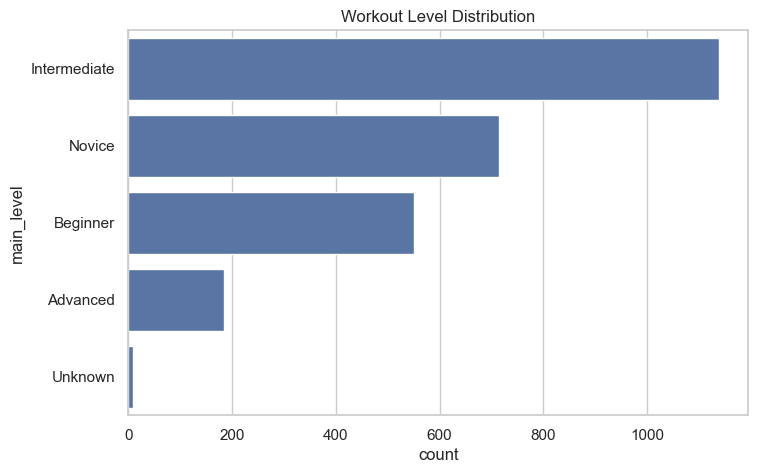

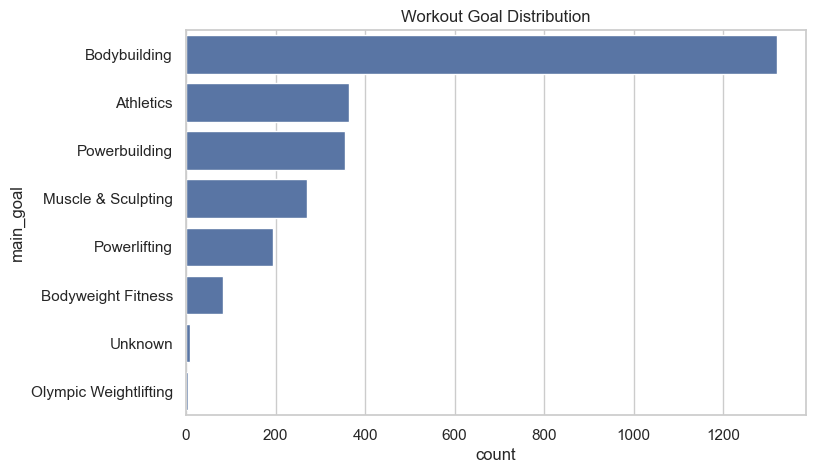

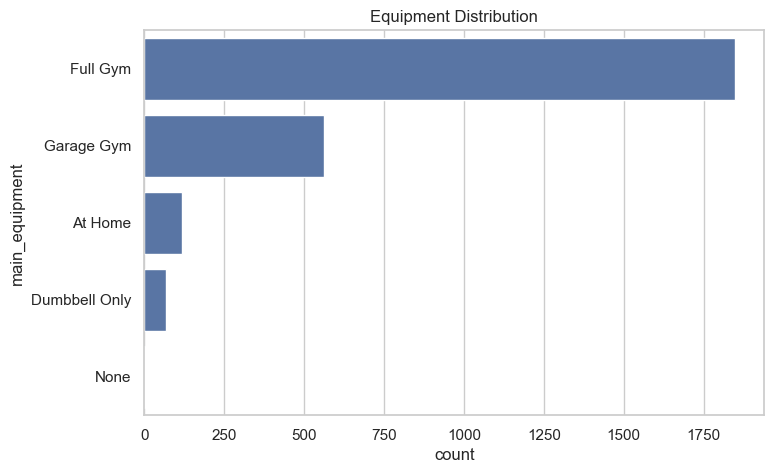

In [31]:
for col in ['main_goal', 'main_level', 'main_equipment']:
    if col in df.columns:
        print(f"\n{col.upper()} value counts:\n", df[col].value_counts().head(10))

#Bar plots
sns.countplot(y='main_level', data=df, order=df['main_level'].value_counts().index)
plt.title('Workout Level Distribution')
plt.show()

sns.countplot(y='main_goal', data=df, order=df['main_goal'].value_counts().index)
plt.title("Workout Goal Distribution")
plt.show()

sns.countplot(y='main_equipment', data=df, order=df['main_equipment'].value_counts().index)
plt.title("Equipment Distribution")
plt.show()

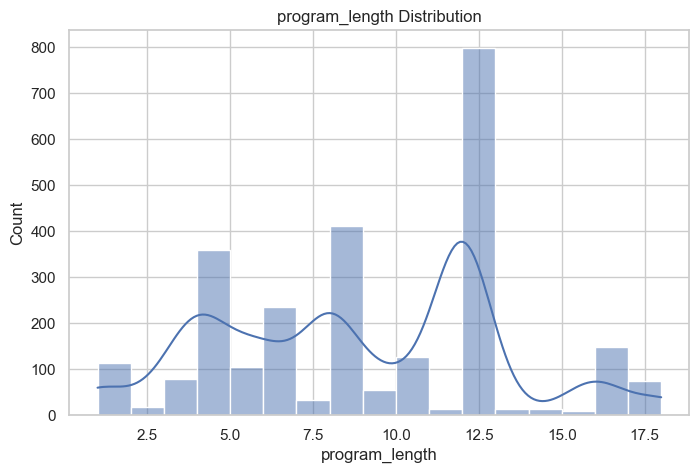

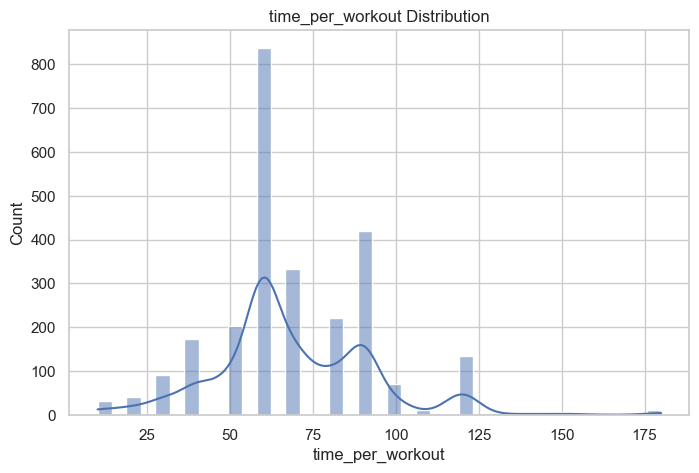

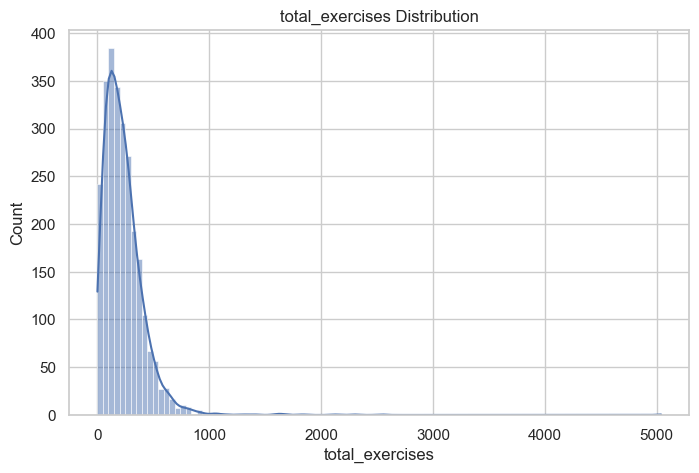

In [32]:
#Numeric Distributions
numeric_cols = ['program_length', 'time_per_workout', 'total_exercises']
for col in numeric_cols:
    if col in df.columns:
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"{col} Distribution")
        plt.show()


Average Program Length and Time per Workout by Level:
               program_length  time_per_workout
main_level                                    
Unknown            10.125000         72.500000
Advanced            9.210811         69.351351
Novice              8.882517         67.510490
Beginner            8.782214         70.471869
Intermediate        8.708516         69.222125


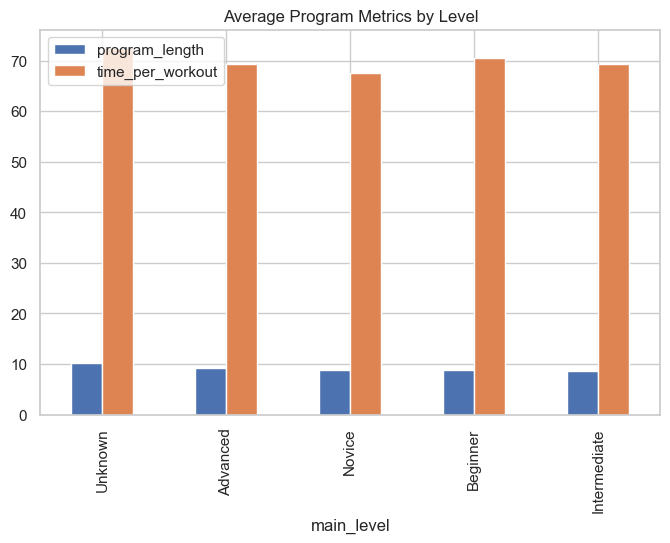

In [33]:
#Average Metrics by Level
if {'program_length', 'time_per_workout', 'main_level'}.issubset(df.columns):
    avg_stats = df.groupby('main_level')[['program_length', 'time_per_workout']].mean().sort_values('program_length', ascending=False)
    print("\nAverage Program Length and Time per Workout by Level:\n", avg_stats)
    avg_stats.plot(kind='bar')
    plt.title("Average Program Metrics by Level")
    plt.show()


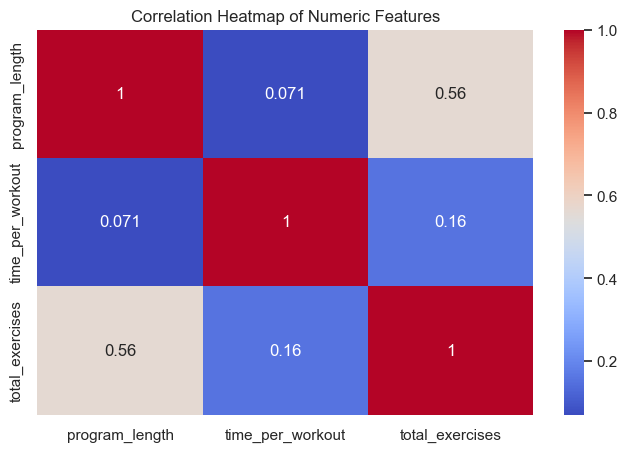

In [34]:
#Correlation heatmap
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


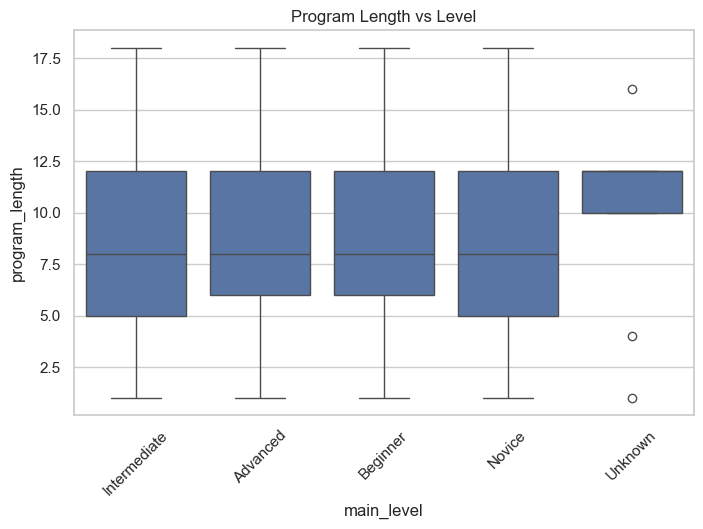

In [35]:
#Boxplot: Program Length vs Level
if {'program_length', 'main_level'}.issubset(df.columns):
    sns.boxplot(data=df, x='main_level', y='program_length')
    plt.title("Program Length vs Level")
    plt.xticks(rotation=45)
    plt.show()


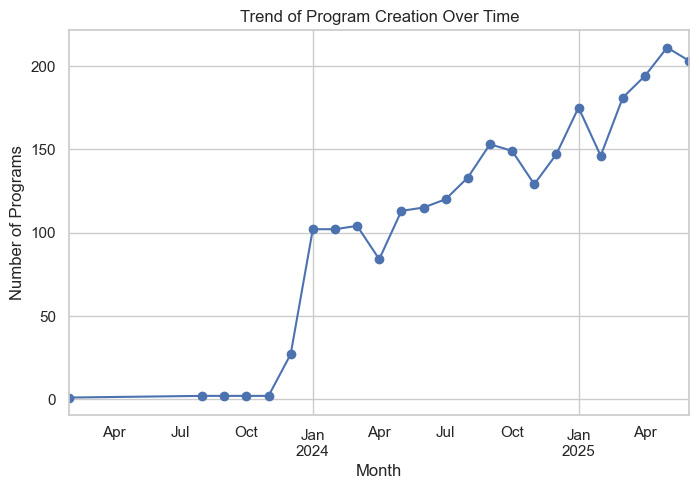

In [36]:
#Time Trend
if 'created' in df.columns:
    df['created_month'] = df['created'].dt.to_period('M')
    trend = df.groupby('created_month').size()
    trend.plot(kind='line', marker='o')
    plt.title("Trend of Program Creation Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Programs")
    plt.show()


In [37]:
#Feature Engineering & Machine Learning
target_col = 'main_goal'  # predict workout goal
feature_cols = ['program_length', 'time_per_workout', 'total_exercises', 'main_level']

df_ml = df.dropna(subset=[target_col])
df_ml = df_ml[df_ml[target_col] != 'Unknown']

X = df_ml[feature_cols]
y = df_ml[target_col]

# Identify categorical vs numeric
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"Categorical columns: {cat_cols}")
print(f"Numerical columns: {num_cols}")

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

Categorical columns: ['main_level']
Numerical columns: ['program_length', 'time_per_workout', 'total_exercises']


In [38]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Logistic Regression Results:
                       precision    recall  f1-score   support

            Athletics       0.00      0.00      0.00        73
         Bodybuilding       0.51      1.00      0.68       264
   Bodyweight Fitness       0.00      0.00      0.00        16
   Muscle & Sculpting       0.00      0.00      0.00        54
Olympic Weightlifting       0.00      0.00      0.00         1
        Powerbuilding       0.00      0.00      0.00        71
         Powerlifting       0.00      0.00      0.00        39

             accuracy                           0.51       518
            macro avg       0.07      0.14      0.10       518
         weighted avg       0.26      0.51      0.34       518



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

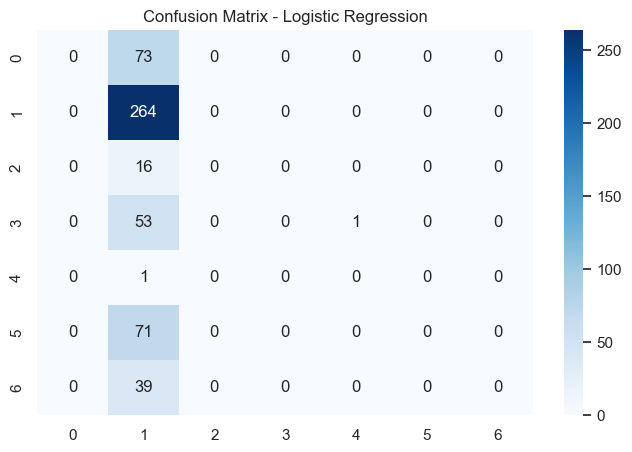

In [39]:
#Logistic Regression
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



Random Forest Results:
                       precision    recall  f1-score   support

            Athletics       0.24      0.16      0.20        73
         Bodybuilding       0.52      0.67      0.59       264
   Bodyweight Fitness       0.00      0.00      0.00        16
   Muscle & Sculpting       0.05      0.04      0.04        54
Olympic Weightlifting       0.00      0.00      0.00         1
        Powerbuilding       0.16      0.13      0.14        71
         Powerlifting       0.00      0.00      0.00        39

             accuracy                           0.38       518
            macro avg       0.14      0.14      0.14       518
         weighted avg       0.33      0.38      0.35       518



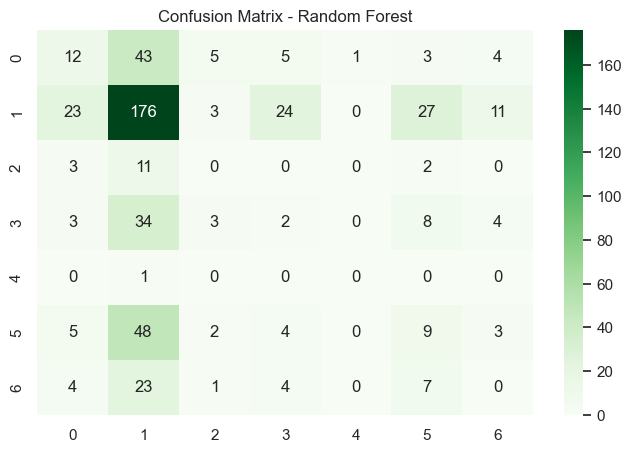

In [40]:
#Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.show()


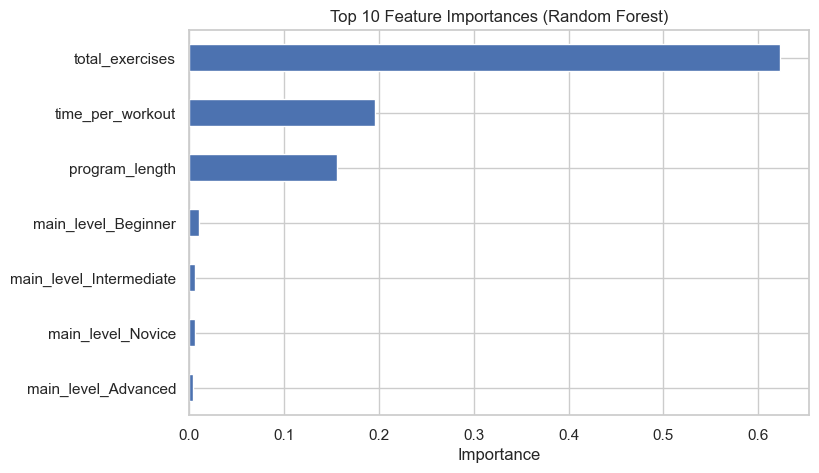

In [41]:
#Feature Importance -Random Forest
rf_model = rf.named_steps['clf']
encoded_cols = num_cols + list(rf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols))
importances = pd.Series(rf_model.feature_importances_, index=encoded_cols).sort_values(ascending=False).head(10)

importances.plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()



In [43]:
summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted')
    ]
})

print('Model Performance Summary')
print(summary)


Model Performance Summary
                 Model  Accuracy  F1 Score
0  Logistic Regression  0.509653  0.344554
1        Random Forest  0.384170  0.350404


In [45]:
example_workout1 = pd.DataFrame({
    'program_length' : [6],
    'time_per_workout' : [45],
    'total_exercises' : [8],
    'main_level' : ['Intermediate']
})

print("\nExample Workout Input:")
display(example_workout1)

#Predict using both trained models
pred_lr = log_reg.predict(example_workout1)[0]
pred_rf = rf.predict(example_workout1)[0]

print(f"\nPredicted Workout Goal (Logistic Regression): {pred_lr}")
print(f"Predicted Workout Goal (Random Forest): {pred_rf}")




Example Workout Input:


,program_length,time_per_workout,total_exercises,main_level
0,6,45,8,Intermediate



Predicted Workout Goal (Logistic Regression): Bodybuilding
Predicted Workout Goal (Random Forest): Powerbuilding


In [46]:
example_workout2 = pd.DataFrame({
    'program_length' : [12],
    'time_per_workout' : [30],
    'total_exercises' : [4],
    'main_level' : ['Beginner']
})

print("\nExample Workout Input:")
display(example_workout2)

#Predict using both trained models
pred_lr = log_reg.predict(example_workout2)[0]
pred_rf = rf.predict(example_workout2)[0]

print(f"\nPredicted Workout Goal (Logistic Regression): {pred_lr}")
print(f"Predicted Workout Goal (Random Forest): {pred_rf}")



Example Workout Input:


,program_length,time_per_workout,total_exercises,main_level
0,12,30,4,Beginner



Predicted Workout Goal (Logistic Regression): Bodybuilding
Predicted Workout Goal (Random Forest): Athletics
